[View in Colaboratory](https://colab.research.google.com/github/Hoiy/kaggle-santander-value-prediction-challenge/blob/master/eda_lightgbm.ipynb)

In [12]:
import pandas as pd
import numpy as np
import dotenv
import os
from scipy import sparse
import pickle
import gc
import lightgbm as lgb

dotenv.load_dotenv('.env')

True

In [85]:
!mkdir prep
!gsutil rsync gs://{os.environ['GCP_BUCKET']}/prep prep

mkdir: prep: File exists
Building synchronization state...
Starting synchronization...


In [0]:
# target_hist.sort_values().reset_index(drop=True).plot.line()
# target_hist[target_hist>=100].index

In [58]:
# X = train[train.columns[2:]]

X = pd.read_parquet('./prep/train_log_stats.snappy.parquet')
# X = pd.read_parquet('./prep/train_log_feats.snappy.parquet')
target = pd.read_parquet('./prep/train_target.snappy.parquet')
# y = train.apply(lambda x: int(sum(x[2:2+4991] == x.target) > 0), axis=1)
target_hist = target.groupby('target').size()

y = target.isin(target_hist[target_hist>=50].index)['target']
X.shape, y.shape

((4459, 12), (4459,))

In [65]:
X[X['count'] == X['unique']]

,count,unique,log_mean,log_median,log_min,log_max,log_25_percentile,log_75_percentile,log_var,log_std,log_skew,log_kurt
ID,,,,,,,,,,,,
008825875,4,4,13.619084,13.542802,12.899220,14.491512,13.203319,13.958567,0.468124,0.684196,0.549829,-0.444246
01a09167b,1,1,16.906553,16.906553,16.906553,16.906553,16.906553,16.906553,NaN,NaN,NaN,NaN
01b4bd64a,6,6,16.785134,16.667402,16.066802,18.197537,16.219462,16.947984,0.613674,0.783373,1.336267,2.022136
0270d1d7b,2,2,16.902404,16.902404,16.300417,17.504390,16.601410,17.203397,0.724775,0.851337,NaN,NaN
08cb967e3,1,1,11.918391,11.918391,11.918391,11.918391,11.918391,11.918391,NaN,NaN,NaN,NaN
0953d0754,8,8,14.847311,15.472604,11.407565,17.602741,13.555251,15.850589,3.785931,1.945747,-0.566296,0.100693
0d6cfdf99,8,8,14.075048,14.089764,9.798127,18.197537,12.552646,15.604164,7.448746,2.729239,-0.043986,-0.413100
16f95b9ee,4,4,15.276332,16.436308,11.002100,17.230611,14.971450,16.741189,8.273178,2.876313,-1.887159,3.656768
1bf991897,1,1,8.294050,8.294050,8.294050,8.294050,8.294050,8.294050,NaN,NaN,NaN,NaN


In [0]:
# target_hist = dfs['train'].groupby('target').size()
# make_up = train[train.target.isin(target_hist[target_hist>=50].index)]
# real = dfs['train'][~dfs['train'].target.isin(target_hist[target_hist>=50].index)]

In [0]:
from sklearn.model_selection import train_test_split

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [0]:
#TODO: how to setup gpu lightgbm in colab
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
#     'min_data_in_leaf': 1000,
#     'num_leaves': 250,
#     'feature_fraction': 0.8,
#     'bagging_freq': 10,
#     'bagging_fraction': 0.5,
#     'max_depth': 8,
#     'min_data_in_leaf': 1000,
#     'device': 'gpu',
#     'num_leaves': 270,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.0175,
    'verbose': 1
}

lgb_params = {
    'verbose_eval': 10,
}

In [63]:
K_FOLD=10

lgb_cv = lgb.Dataset(X_cv, y_cv, feature_name=X.columns.tolist())
results = lgb.cv(
    params,
    lgb_cv,
#     stratified=False,
    nfold=K_FOLD,
    seed=42,
    num_boost_round=10000,
    early_stopping_rounds=10,
    **lgb_params
)

[10]	cv_agg's auc: 0.720486 + 0.037367
[20]	cv_agg's auc: 0.724937 + 0.0370269
[30]	cv_agg's auc: 0.725766 + 0.0353813
[40]	cv_agg's auc: 0.727163 + 0.034513
[50]	cv_agg's auc: 0.729302 + 0.0348872
[60]	cv_agg's auc: 0.730007 + 0.0339099
[70]	cv_agg's auc: 0.729887 + 0.0338547


In [60]:
cv = results['auc-mean'][-1]
rounds = len(results['auc-mean'])
rounds, cv, K_FOLD, 1/K_FOLD

(15, 0.6649784226103126, 10, 0.1)

In [61]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.3, random_state=777, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_cv, y_cv, test_size=0.2, random_state=888, shuffle=True)

lgb_train = lgb.Dataset(X_train, y_train, feature_name=X.columns.tolist())
lgb_val = lgb.Dataset(X_val, y_val, feature_name=X.columns.tolist(), reference=lgb_train)

lgb_test = lgb.Dataset(X_test, y_test, feature_name=X.columns.tolist())

model = lgb.train(
    params,
    lgb_train,
    valid_names=['train', 'val', 'test'],
    valid_sets=[lgb_train, lgb_val, lgb_test],
    num_boost_round=rounds,
    **lgb_params
)

X_train.shape, X_val.shape, X_test.shape, 

[10]	train's auc: 0.914934	val's auc: 0.629247	test's auc: 0.640426


((2496, 5013), (625, 5013), (1338, 5013))

In [0]:
from sklearn.metrics import mean_squared_error

pred = model.predict(X)
np.sqrt(mean_squared_error(y, pred))

1.1586273863017356

In [0]:
PSEUDO_DATA_CUTOFF = 8

target_hist = train.groupby('target').size()
thresholds = target_hist[target_hist >= PSEUDO_DATA_CUTOFF].index

def find_nearest(pred, thresholds):
  if pred < thresholds[0]:
    return thresholds[0]

  # pred >= thresholds[0]
  prev_diff = pred - thresholds[0]
  for i in range(len(thresholds)-1):
    if pred >= thresholds[i] and pred < thresholds[i+1]:
      if prev_diff <= thresholds[i+1] - pred:
        return thresholds[i]
      else:
        return thresholds[i+1]
  
  return thresholds[-1]

fixed_pred = []
for p in pred:
  fixed_pred.append(find_nearest(p, thresholds))
  
np.sqrt(mean_squared_error(y, fixed_pred))

1.1606566031196968

In [0]:
model

Text(0.5,1,'Light GBM Feature Importance')

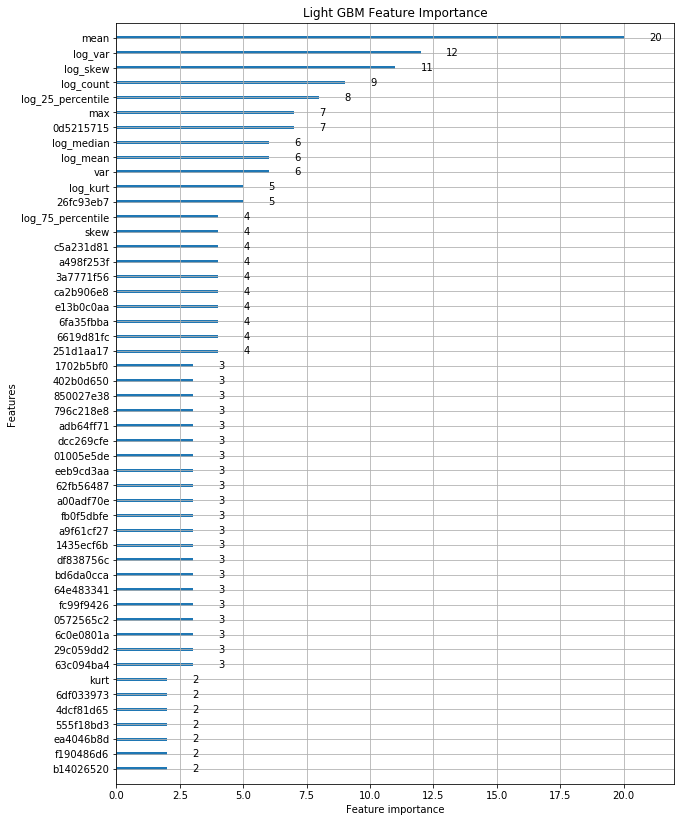

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 14))
lgb.plot_importance(model, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [0]:
model.best_score

defaultdict(dict,
            {'test': {'rmse': 1.306083185595861},
             'train': {'rmse': 1.0598935025033185}})

In [0]:
!mkdir ./model
model.save_model('./model/lightgbm.dat')
!gsutil rsync model gs://{os.environ['GCP_BUCKET']}/model

Building synchronization state...
Starting synchronization...
Copying file://model/lightgbm.dat [Content-Type=application/octet-stream]...
/ [1 files][630.1 KiB/630.1 KiB]                                                
Operation completed over 1 objects/630.1 KiB.                                    


In [0]:
!mkdir model
!gsutil rsync gs://{os.environ['GCP_BUCKET']}/model model
  
model = lgb.Booster(model_file='./model/lightgbm.dat')

Building synchronization state...
Starting synchronization...
Copying gs://kaggle-195720-santander-value-prediction-challenge/model/lightgbm.dat...
- [1 files][630.1 KiB/630.1 KiB]                                                
Operation completed over 1 objects/630.1 KiB.                                    


In [0]:
test = pd.read_csv('./prep/test.csv.gz')
X_test = test[test.columns[1:]]

In [0]:
SUBMISSION_FILE = 'lightgbm.csv'
# SUBMISSION_MESSAGE='"LightGBM train %.4f test %.4f"'%(model.best_score['train']['rmse'], model.best_score['test']['rmse'])
SUBMISSION_MESSAGE='"LightGBM train %.4f test %.4f"'%(1.059, 1.306)

# TODO: how to limit LightGBM regression mode to output [0., 1]
test['target'] = np.exp(model.predict(X_test))
test[['ID', 'target']].to_csv(SUBMISSION_FILE, index=False)
print(SUBMISSION_MESSAGE)

"LightGBM train 1.0590 test 1.3060"


In [0]:
!head ./lightgbm.csv

ID,target
000137c73,2276017.838533199
00021489f,1728607.5919792475
0004d7953,2086590.425491383
00056a333,4232045.657810334
00056d8eb,2280690.9304585312
0005fc190,3359461.571138545
000787e86,2077704.207207256
0008510a0,2868223.250316971
000895faf,2415957.6023148457


In [0]:
!kaggle competitions submit -f '{SUBMISSION_FILE}' -m '{SUBMISSION_MESSAGE}'

Using competition: santander-value-prediction-challenge
Successfully submitted to Santander Value Prediction Challenge